In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")


In [2]:
history_df = pd.read_csv("Coca-Cola_stock_history.csv")
info_df = pd.read_csv("Coca-Cola_stock_info.csv")

print(history_df.head())
print(history_df.info())


         Date      Open      High       Low     Close   Volume  Dividends  \
0  1962-01-02  0.050016  0.051378  0.050016  0.050016   806400        0.0   
1  1962-01-03  0.049273  0.049273  0.048159  0.048902  1574400        0.0   
2  1962-01-04  0.049026  0.049645  0.049026  0.049273   844800        0.0   
3  1962-01-05  0.049273  0.049892  0.048035  0.048159  1420800        0.0   
4  1962-01-08  0.047787  0.047787  0.046735  0.047664  2035200        0.0   

   Stock Splits  
0             0  
1             0  
2             0  
3             0  
4             0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15311 entries, 0 to 15310
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          15311 non-null  object 
 1   Open          15311 non-null  float64
 2   High          15311 non-null  float64
 3   Low           15311 non-null  float64
 4   Close         15311 non-null  float64
 5   Volume        1

In [3]:
# Convert Date column safely (handles timezone & mixed formats)

history_df['Date'] = pd.to_datetime(
    history_df['Date'],
    errors='coerce',
    utc=True
)

# Remove timezone info

history_df['Date'] = history_df['Date'].dt.tz_localize(None)

# Sort by date

history_df.sort_values('Date', inplace=True)

# Reset index

history_df.reset_index(drop=True, inplace=True)

history_df[['Date']].head()


,Date
0,1962-01-02
1,1962-01-03
2,1962-01-04
3,1962-01-05
4,1962-01-08


In [4]:
print("Missing values before cleaning:\n", history_df.isnull().sum())

# Forward fill stock data

history_df.fillna(method='ffill', inplace=True)

# Replace remaining NaNs

history_df.fillna(0, inplace=True)

print("\nMissing values after cleaning:\n", history_df.isnull().sum())


Missing values before cleaning:
 Date            8840
Open               0
High               0
Low                0
Close              0
Volume             0
Dividends          0
Stock Splits       0
dtype: int64

Missing values after cleaning:
 Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64


In [5]:
# Moving averages

history_df['MA_20'] = history_df['Close'].rolling(20).mean()
history_df['MA_50'] = history_df['Close'].rolling(50).mean()

# Daily returns

history_df['Daily_Return'] = history_df['Close'].pct_change()

# Volatility

history_df['Volatility'] = history_df['Daily_Return'].rolling(20).std()

# Remove rows with NaN from rolling

history_df.dropna(inplace=True)

history_df.head()


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA_20,MA_50,Daily_Return,Volatility
49,1962-03-13,0.046416,0.046789,0.046416,0.046789,1344000,0.001563,0,0.045788,0.046525,0.015962,0.013223
50,1962-03-14,0.046789,0.046976,0.046603,0.046852,1689600,0.000000,0,0.045797,0.046461,0.001334,0.013226
51,1962-03-15,0.046852,0.046976,0.046603,0.046603,883200,0.000000,0,0.045836,0.046415,-0.005320,0.012546
52,1962-03-16,0.046603,0.046789,0.046603,0.046603,768000,0.000000,0,0.045889,0.046362,0.000000,0.012460
53,1962-03-19,0.046603,0.047101,0.046603,0.046852,921600,0.000000,0,0.045953,0.046336,0.005348,0.012491


In [6]:
history_df.describe()


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA_20,MA_50,Daily_Return,Volatility
count,15262,15262.000000,15262.000000,15262.000000,15262.000000,1.526200e+04,15262.000000,15262.000000,15262.000000,15262.000000,15262.000000,15262.000000
mean,2008-11-08 15:36:49.251736576,11.850660,11.944785,11.754847,11.853194,9.164087e+06,0.001683,0.001114,11.818108,11.760960,0.001085,0.016505
min,1962-03-13 00:00:00,0.037154,0.037279,0.034890,0.037028,7.680000e+04,0.000000,0.000000,0.038886,0.040157,-0.999186,0.003213
25%,1995-02-07 06:00:00,0.239461,0.241549,0.237297,0.239432,2.947200e+06,0.000000,0.000000,0.239635,0.237319,-0.006788,0.009429
50%,2022-03-11 00:00:00,4.959658,5.012348,4.918166,4.959969,7.732300e+06,0.000000,0.000000,4.989825,4.984838,0.000000,0.012666
75%,2022-03-11 00:00:00,17.425250,17.663839,17.230594,17.456363,1.309292e+07,0.000000,0.000000,17.279994,17.275054,0.007731,0.017295
max,2022-03-11 00:00:00,66.037933,66.235058,64.776308,65.259270,1.241690e+08,0.440000,3.000000,64.089813,63.021674,0.677367,0.223954
std,NaN,15.035006,15.142659,14.924814,15.035590,7.957132e+06,0.021336,0.049226,14.963539,14.846345,0.022708,0.015669


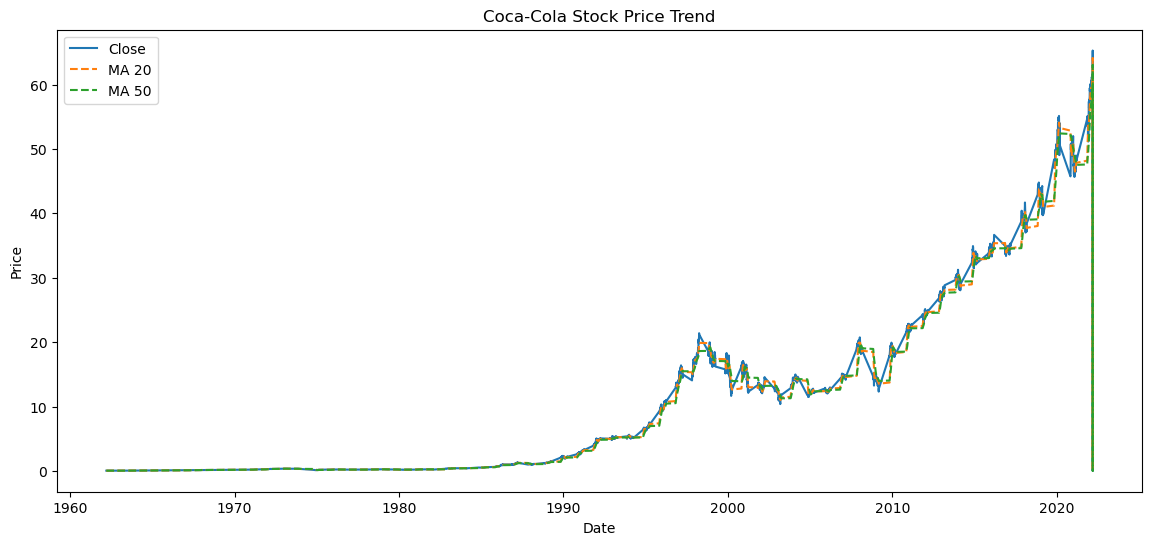

In [7]:
plt.figure(figsize=(14,6))
plt.plot(history_df['Date'], history_df['Close'], label='Close')
plt.plot(history_df['Date'], history_df['MA_20'], '--', label='MA 20')
plt.plot(history_df['Date'], history_df['MA_50'], '--', label='MA 50')

plt.title("Coca-Cola Stock Price Trend")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


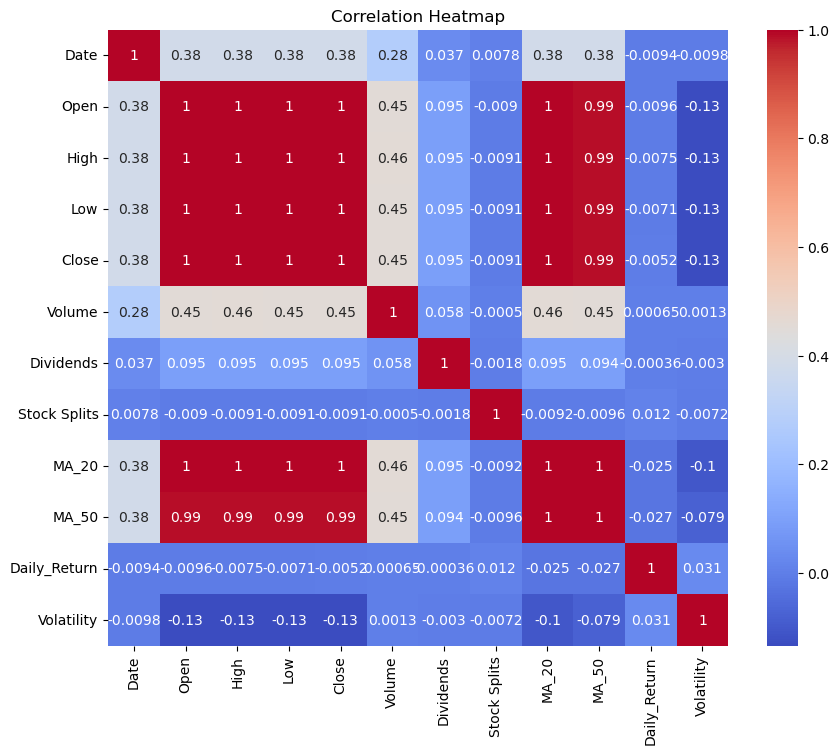

In [8]:
plt.figure(figsize=(10,8))
sns.heatmap(history_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [9]:
features = [
    'Open', 'High', 'Low', 'Volume',
    'Dividends', 'Stock Splits',
    'MA_20', 'MA_50',
    'Daily_Return', 'Volatility'
]

target = 'Close'

X = history_df[features]
y = history_df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


In [10]:
model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)


RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

In [11]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error :", mse)
print("Mean Absolute Error:", mae)


Mean Squared Error : 0.2077385741715037
Mean Absolute Error: 0.19046856765450154


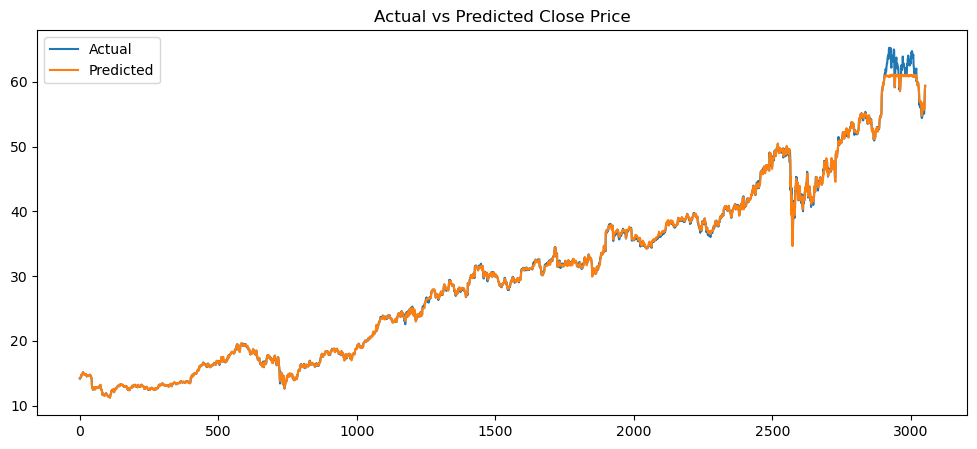

In [12]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Actual vs Predicted Close Price")
plt.legend()
plt.show()


In [13]:
latest_data = history_df[features].iloc[-1:]

next_close_price = model.predict(latest_data)

print("Predicted Next Closing Price:", round(next_close_price[0], 2))


Predicted Next Closing Price: 59.37


In [14]:
import joblib
joblib.dump(model, "coca_cola_stock_model.pkl")


['coca_cola_stock_model.pkl']